# Notebook description

This notebook explores the possibility of building a collaborative filtering recommender based on the available reviews table. First, short introduction to recommenders is given, focusing on collaborative filtering recommenders and in particular on PureSVD, the recommender implemented for this experiment. Then the implemented recommender is evaluated.

The notebook import two modules: _recommender_ and _evaluation_, which are described below.

# Extremely brief introduction to recommenders

## Overview

A simple recommender was implemented and evaluated. A brief introduction to recommenders is in order before describing the code and the results for such implementation.

The main goal of a recommender system is usually increasing sales and user satisfaction. By recommending the right items, recommender systems bring relevant items to the attention of users. Most recommenders are based on the so called __rating matrix__. A rating matrix $ R $ is just a _number of users_ x _number of items_ matrix such that $ R_{u,i} $ indicates user $ u $ preference for item $ i $. This matrix can be obtained in different ways depending on the available data (more on this later). Recommendation for a given user $u$ usually proceedes by first __scoring__ each available item (based on $u$'s preferences) and then recommending items with the largest scores.

Two well accepted categories of recommender algorithms can be mention:
1. content-based
2. collaborative filtering

__Content-based__ recommenders are based on item features, such as color, size, price, free text description, etc. The main assumption of this kind of recommenders is that such features can determine how relevant an item is for a given user. A user profile is obtained by training a model based on item features and user past ratings. This is training step is just a traditional machine learning regression/classification training step. 

The ratings of the other users are not taken into account in content-based recommenders. This reduces the novelty of the recommended items. Recommended items have often similar features to items previuosly liked by the user (this makes sense, because the trained model is based solely on a fixed set of features). Nevertheless, content-based recommenders do have several advantages, as discussed later.

__Collaborative filtering__ recommenders, on the other hand, suggest items to a given user based on the other users’ ratings. The central idea of this algorithms is that different items can be strongly correlated in terms of the ratings the users give them. This is crucially different than content-based approaches: two items A and B with completely different feature values (color, size, price, etc) can be considered similar because many users gave both items similar ratings; as a consequence, a certain user who liked A, can get B recommended. Collaborative systems have also important limitations, as commented later.

While both kinds of recommenders leverage user's past ratings to infer relevant recommendations, only the latter takes fully advantage of the whole rating matrix.

The recommender implemented for this project is a collaborative filtering method, knwon as __PureSVD__.

A comprehensive description of the different kinds of recommenders can be found in [this book by Charu Aggarwal](http://www.springer.com/la/book/9783319296579)

## Pure SVD

PureSVD is a kind of __latent factor__ model. The main idea of this kind of models is that the rating matrix _overspecifies_ users tastes and items features. For example, knowing that a user liked three Indian food restaurants suggests that the user is into Indian food. However, the specific Indian restaurants that the user liked might not be that relevant. Based on this observation, these models try to describe users and items in terms of _latent factors_ that describe user preferences and item characteristics in a compact way. User descriptions, orginally vectors of size _number of items_, are thus reduced to much smaller vectors of key hidden features. Similarly, item descriptions, originally vectors of size _number of users_, are reduced to vectors of the same key features.

Specifically, these models approximate the rating matrix $R$ using two lower rank matrices, one ($U$, in $\mathbb{R}^{n \times f}$) corresponding to __user factors__ and the other one ($Q$, in $\mathbb{R}^{m \times f}$) to __item factors__. as:
$$
\hat{R} = U \Sigma Q^T
$$

where $\Sigma$ is diagonal matrix in $\mathbb{R}^{f \times f}$ containing the first $f$ singular values of $R$'s SVD decomposition.

$Q$ rows correspond to item factors. Each item $i$ is represented as an $f$-dimensional vector $q_i$ ($Q$'s $i^{th}$ row). 

With a little bit of algebra, it can be shown that scoring for user $u$ and item $i$ (that is, $u$'s estimated rating for $i$) can be computed as:
$$
\hat{r_{u,i}} = r_u Q q_i^T
$$

where $r_u$ is $u$'s row in $R$ (the rating matrix)

The description above includes the basic knowledge to understand the main idea of the recommender implemented for the project. Much more details can be found in [Cremonesi et al., 2010](https://www.researchgate.net/profile/Paolo_Cremonesi/publication/221141030_Performance_of_recommender_algorithms_on_top-N_recommendation_tasks/links/55ef4ac808ae0af8ee1b1bd0.pdf).

## Evaluation

To estimate the performance of the implemented recommender, the evaluation procedure of [Cremonesi et al., 2010](https://www.researchgate.net/profile/Paolo_Cremonesi/publication/221141030_Performance_of_recommender_algorithms_on_top-N_recommendation_tasks/links/55ef4ac808ae0af8ee1b1bd0.pdf) is followed. 

Specifically, users are randomly splitted into 10 folds and, in turn, performance is computed on one fold while the remaining 9 folds are used to train the recommender. Reported performance is the average performance among the 10 folds.

Performance in a single fold is computed in the following way:
- For each user $u$ in the test fold, a business $i$ rated by $u$ is selected. 
- $i$ is removed from $u$'s ratings, and a score is estimated for $i$ using this modified version of the user's ratings.
- Scores are also estimated for $k$ other randomly selected businesses unrated by $u$. An assumption is made here: those unrated businesses are not of interest to $u$.
- A ranked list is formed by ordering the $k$ + 1 scores (that is, the scores corresponding to the $k$ randomly selected businesses plus $i$)
- A top-$N$ recommendation list is formed by picking the top $N$ ranked businesses from the ranked list. If $i$ is within the $N$ recommended businesses, there's a _hit_. Otherwise, there's a _miss_. Note that chances of hit increase with $N$.
- The procedure above is repeated for every rated business of every user in the test fold. Performance for a given fold is computed by the $recall$ as:

$$
recall = \frac{\#hits}{T}
$$

where $T$ is the number of tests ratings.

Note that the assumption that the $k$ unrated businesses are not of interest to $u$ tends to underestimate the actual recall. 

The procedure described above is an example of offline evaluation. While useful to tune models, these kind of procedures are not enough to really assess the efectiveness of the recommender. In a realistic setting, at some point online evaluations through A / B testing should be put in place. 

## Implementation

The code in this notebook imports two python modules: _recommender_ and _evaluation_


_recommender_ contains 3 classes: 
 
 1. _Recommender_: This abstract class contains methods that are meant to be exposed by every recommender. It also provides some functionality common to all recommenders. 
 2. _PureSVDRecommender_: Implements the PureSVD recommender described above.
 3. _RandomRecommender_: Implements a random recommender. Provides a trivial baseline against which to compare PureSVD.

_Recommender_ defines also 3 abstract methods (see comments in code for a description): _train_, _score_ and, _def when trained_ . These methods are declared abstract to force concrete classes inheriting from _Recommender_ to implement them.

_Recommender_ class also includes 3 non-abstract methods: _fit_, _check is fitted_ and _recommend_, non intended to be overridden. These methods call _train_, _score_ and _def when trained_ at different points in the code, effectively implementing the template method design pattern, avoiding code duplication and restricting the parts of the general workflow that are allowed to change.

This little class hierarchy is of course a toy  example, and can definitely be improved (for example, a much more thorough analysis should be done to understand if this sort of design is reasonable to model the wide variety of existing recommenders). The idea here was to showcase a bit of OOP knowledge. 

_evaluation_ contains just two functions, that implement the evaluation procedure described above.

# Experiment using YELP reviews

The implemented recommender is tested using the YELP reviews.

We only consider reviews corresponding to businesses in a specific city. This will allow for lower running times and should not affect too much the usefulness of the recommendations (since in most cases recommending businesses from a different city would not make much sense)  .

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from recommender import *
from evaluation import *
from scipy.sparse import csc_matrix

## Params

In [2]:
# General
random_state = 0
verbose = False
city = 'Phoenix'

# Paths
reviews_path = '../data/reviews.csv'
businesses_path = '../data/businesses.csv'

# Cold start
min_reviews_th = 10 # Those users/businesses with less than min_reviews_th reviews will be excluded

# Sample 
# If sample=True, it will sample the original ratings matrix to 
# a n_users_sample x n_businesses_sample matrix. 
# Sampling is for faster evaluation. When sample=False, evaluation
# of PureSVD takes about 16 hours on an i7 with 8 cores and 8GB RAM 
# (implementation is quite naive though)
sample = True
n_users_sample = 3000 # 3000 is about 33% of the users with reviews in Phoenix (excluding cold starters)
n_businesses_sample = 3000 # 3000 is about 33% of the businesses in Phoenix (excluding cold starters)

# PureSVDRecommender
n_factors = 15 # Number of factors used to describe users/businesses (see Pure SVD section above)
top_n = 10 # Number of businesses to recommend

# Testing
negs_hit_test = 300
n_fold = 10
test_rtg_th = 5
verbose = True

## Analyse reviews, train and evaluate collaborative filtering

First, let us read the reviews and keep only those for the considered city

In [3]:
ratings_df = pd.read_csv(reviews_path, 
                      usecols=['user_id', 'business_id', 'stars'], engine='python')
ratings_df = ratings_df[['user_id', 'business_id', 'stars']]
ratings_df.columns = ['user_id', 'business_id', 'rating']
businesses_df = pd.read_csv(businesses_path, usecols=['business_id', 'city'])
businesses_df = businesses_df[businesses_df.city == city][['business_id']]
ratings_df = ratings_df.merge(businesses_df, on='business_id')
ratings_df['user_idx'] = ratings_df.user_id.astype('category').cat.codes
ratings_df['business_idx'] = ratings_df.business_id.astype('category').cat.codes
ratings_df = ratings_df[['user_idx', 'business_idx', 'rating']]

Basic checks: how many users/businesses have at least one review

In [4]:
n_users = ratings_df.user_idx.nunique()
print('{} users have at least one review'.format(n_users))
n_businesses = ratings_df.business_idx.nunique()
print('{} businesses have at least one review'.format(n_businesses))

237700 users have at least one review
18633 businesses have at least one review


Get idea of the number of reviews per user

<IPython.core.display.Javascript object>


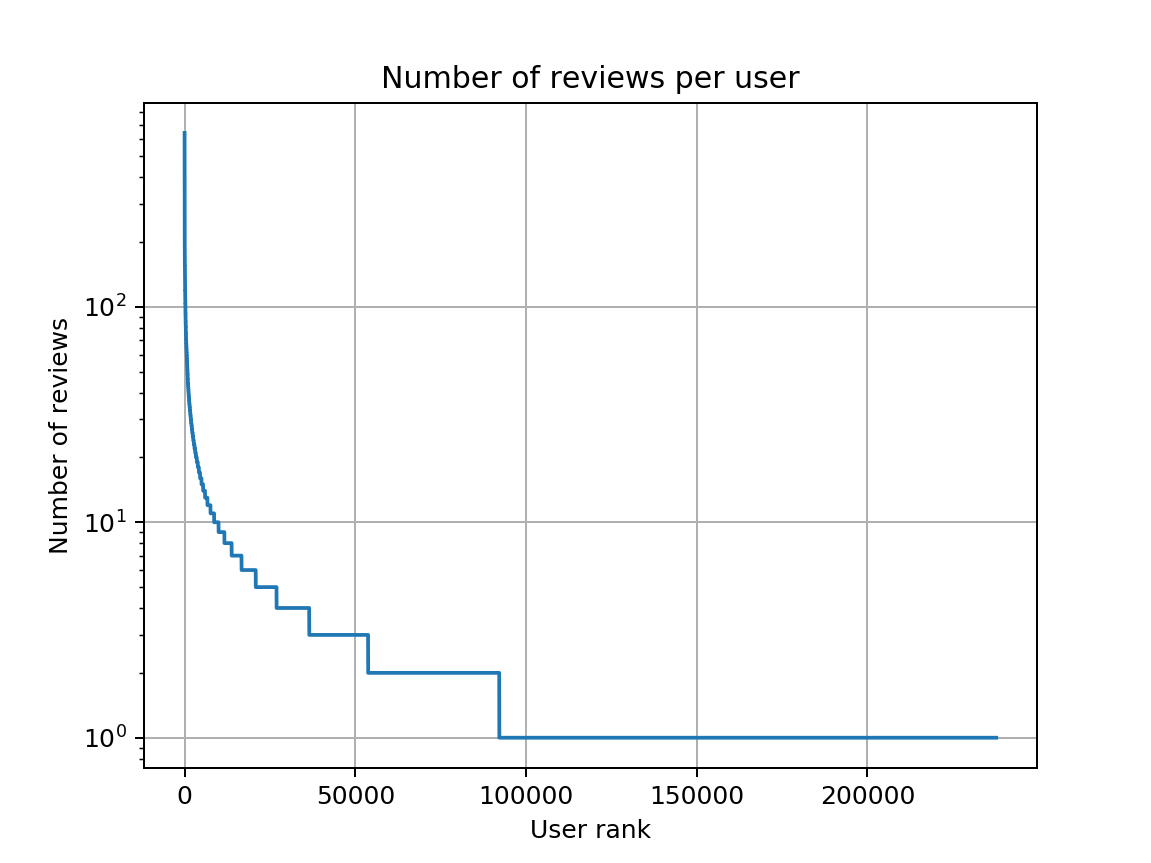

In [5]:
%matplotlib notebook
reviews_per_user_df = ratings_df.user_idx.value_counts().reset_index()
reviews_per_user_df.columns = ['user_idx', 'n_reviews']
reviews_per_user = reviews_per_user_df.n_reviews.values
_ = plt.plot(reviews_per_user)
plt.yscale("log")
plt.grid()
_ = plt.xlabel('User rank')
_ = plt.ylabel('Number of reviews')
_ = plt.title("Number of reviews per user")
plt.show()

The plot shows that most of the users have a low number of reviews. For example, let us see how many users have only one review:

In [6]:
only_one = 100 * sum(reviews_per_user == 1) / float(n_users)
print('{0:.2f} % of the users have only one review'.format(only_one))

61.23 % of the users have only one review


This is a common scenario in recommendation problems. 

A collaborative filtering approach will not work for those users/businesses with a really low number of reviews (this is known as the _cold start problem_). Business and user static features should be used for them instead. Methods based on global stats (such as recommending the top reviewed business) could help as well. For our collaborative filtering experiment, we filter out reviews corresponding to users/businesses with less than a certain number of reviews.  

In [7]:
non_cold_users = reviews_per_user_df[reviews_per_user_df.n_reviews >= min_reviews_th][['user_idx']]
reviews_per_business_df = ratings_df.business_idx .value_counts().reset_index()
reviews_per_business_df.columns = ['business_idx', 'n_reviews']
non_cold_businesses = reviews_per_business_df[reviews_per_business_df.n_reviews >= min_reviews_th
                                             ][['business_idx']]
print('We keep ratings for those users/businesses with {} reviews or more'.format(min_reviews_th))
ratings_df = ratings_df.merge(non_cold_users, on='user_idx').merge(non_cold_businesses, on='business_idx')
print('After filtering, we get a ratings table with:')
n_users = ratings_df.user_idx.nunique()
print('{} users.'.format(n_users))
n_businesses = ratings_df.business_idx.nunique()
print('{} businesses.'.format(n_businesses))

We keep ratings for those users/businesses with 10 reviews or more
After filtering, we get a ratings table with:
9937 users.
9060 businesses.


Create rating matrix

In [8]:
ratings_df.set_index(['user_idx', 'business_idx'], inplace=True)
ratings = csc_matrix((ratings_df.rating, (ratings_df.index.labels[0], ratings_df.index.labels[1])))

Sample rating matrix (for faster evaluation) if requested

In [9]:
if sample:
    np.random.seed(random_state)
    ratings = ratings[np.random.choice(n_users, n_users_sample, replace=False)
                     ][:, np.random.choice(n_businesses, n_businesses_sample, replace=False)]
    n_users = ratings.shape[0]
    n_businesses = ratings.shape[1]

Check rating matrix density

In [10]:
density = 100 * (ratings > 0).sum() / float(ratings.shape[0] * ratings.shape[1])
print('Ratings matrix density is {0:.2f}%'.format(density))

Ratings matrix density is 0.25%


Let us now evaluate the PureSVD collaborative filtering recommender (took about 15 minutes for a 3000 x 3000 ratings matrix)

In [11]:
ratings = ratings.asfptype()
recommender = PureSVDRecommender(n_factors)
ar = average_recall(recommender, ratings, test_rtg_th, negs_hit_test, top_n, n_fold=n_fold, 
                    random_state=random_state, verbose=verbose)
print("Recall for the pure SVD recommender is {0:.2f}".format(ar))

Fold 0 out of 10
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Recall for the pure SVD recommender is 0.33


Let us now compare with naive RandomRecommender performance

In [12]:
recommender = RandomRecommender()
ar_random = average_recall(recommender, ratings, test_rtg_th, negs_hit_test, top_n, n_fold=n_fold, 
                           random_state=random_state, verbose=verbose)
print("Recall for the random recommender is {0:.2f}".format(ar_random))

Fold 0 out of 10
Fold 1 out of 10
Fold 2 out of 10
Fold 3 out of 10
Fold 4 out of 10
Fold 5 out of 10
Fold 6 out of 10
Fold 7 out of 10
Fold 8 out of 10
Fold 9 out of 10
Recall for the random recommender is 0.03


In [13]:
print('Recall for PureSVD is {:.3} times the recall for the random recommender'.format(ar/ar_random))

Recall for PureSVD is 9.61 times the recall for the random recommender


So PureSVD gives a reasonable improvement in terms of recall compared with naive random recommendation. Random recommendation is of course a very basic baseline to compare against. With more time, it would be interesting to compare against a recommender that scores businesses according to their popularity (i.e., number of reviews). In that scenario, it would be particularly interesting to test only on the businesses in the long tail(that is, businesses with a low number of reviews). Popularity-based recommenders will probably miss those businesses, while recommenders based on collaborative filtering should be able to take them into account. 

As a final comment, note that I have not tune at all the main hyperparameter of the PureSVD recommender: the number of factors used to describe users and businesses (n_factors parameter). I simply picked a value that sounded roughly reasonable. With more time, a grid search should be performed on different values, and the final performance for the selected value estimated on a held out dataset.